# Assignment

z5544290
Hongliang Zhang

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords', quiet=True)

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Part 1: Topic Classification

## Q1. Simplifications
### Issue 1: The regex might remove too many special characters (following code)
-  Use `r'\b\w+\b'` to preserve contractions

### Issue 2: Evaluation based on single train-test split (the code are on Q3)
- Implement stratified 5-fold cross-validation to handle class imbalance

In [4]:
df = pd.read_csv('dataset.tsv', sep='\t')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTopic distribution:")
print(df['topic'].value_counts())

print(f"\nMissing values:")
print(df.isnull().sum())

def create_combined_document(row):
    return f"{row['artist_name']} {row['track_name']} {row['genre']} {row['lyrics']}"

df['combined_text'] = df.apply(create_combined_document, axis=1)

# Improved tokenizer function (fixes Issue 1)
def improved_tokenizer(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

print("\nData loaded")

Dataset shape: (1500, 6)
Columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']

Topic distribution:
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64

Missing values:
artist_name     0
track_name      0
release_date    0
genre           0
lyrics          0
topic           0
dtype: int64

Data loaded


## Q2. Text Preprocessing Optimization
The following pipeline was determined to be optimal through experimentation:

In [6]:
def optimal_preprocessor(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    
    stop_words = set(stopwords.words('english'))
    stop_words.update(['im', 'dont', 'youre', 'ive', 'theyre', 'wont', 'cant', 
                      'aint', 'isnt', 'arent', 'wasnt', 'werent', 'hasnt', 'havent',
                      'hadnt', 'woudnt', 'shouldnt', 'couldnt', 'mustnt'])
    
    tokens = [token for token in tokens if token not in stop_words and len(token) >= 3]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return " ".join(tokens)

## Q3. BNB vs. MNB

- use Stratified 5-fold cross-validation to fixes Issue 2
- use Accuracy, F1-macro as metrics


Accuracy Results:
BNB Accuracy: 0.6087 (±0.0209)
MNB Accuracy: 0.8033 (±0.0233)

F1-Macro Results:
BNB F1-macro: 0.4772 (±0.0269)
MNB F1-macro: 0.7640 (±0.0283)


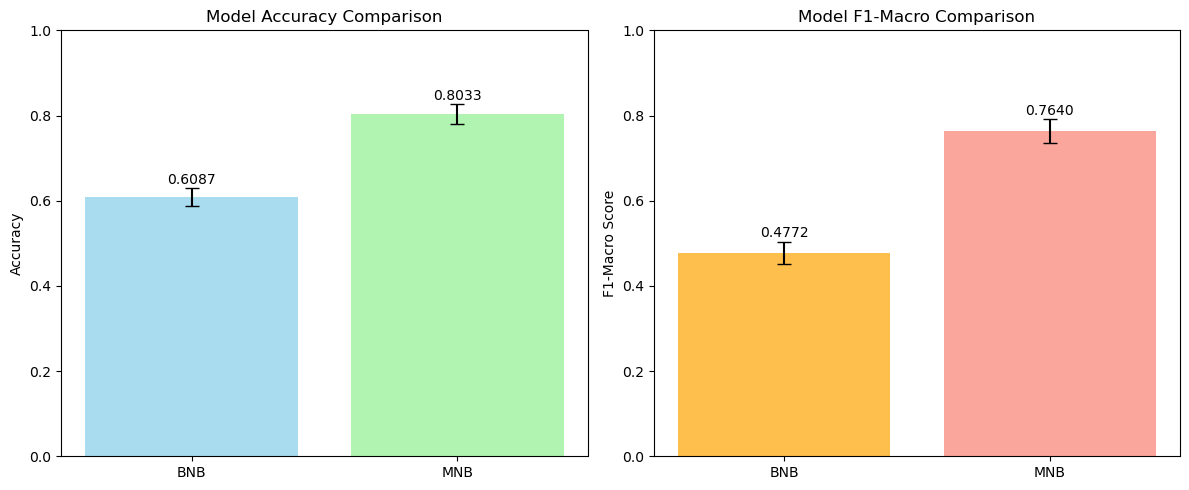


Conclusion: MNB performs better with F1-macro of 0.7640


In [8]:
# print("Preprocessing all combined text...")
df['processed_text'] = df['combined_text'].apply(optimal_preprocessor)
#print(f"Preprocessing completed for {len(df)} songs.")

#print("Creating feature vectors...")
vectorizer = CountVectorizer(max_features=2500) 
X = vectorizer.fit_transform(df['processed_text'])
y = df['topic']
#print(f"Feature matrix shape: {X.shape}")


bnb = BernoulliNB()
mnb = MultinomialNB()

# Setup cross-validation (fixes Issue 2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#print("\nPerforming 5-fold stratified cross-validation...")


bnb_acc_scores = cross_val_score(bnb, X, y, cv=cv, scoring='accuracy')
mnb_acc_scores = cross_val_score(mnb, X, y, cv=cv, scoring='accuracy')

print(f"\nAccuracy Results:")
print(f"BNB Accuracy: {np.mean(bnb_acc_scores):.4f} (±{np.std(bnb_acc_scores):.4f})")
print(f"MNB Accuracy: {np.mean(mnb_acc_scores):.4f} (±{np.std(mnb_acc_scores):.4f})")

# FI-score
bnb_f1_scores = cross_val_score(bnb, X, y, cv=cv, scoring='f1_macro')
mnb_f1_scores = cross_val_score(mnb, X, y, cv=cv, scoring='f1_macro')

print(f"\nF1-Macro Results:")
print(f"BNB F1-macro: {np.mean(bnb_f1_scores):.4f} (±{np.std(bnb_f1_scores):.4f})")
print(f"MNB F1-macro: {np.mean(mnb_f1_scores):.4f} (±{np.std(mnb_f1_scores):.4f})")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
models = ['BNB', 'MNB']
acc_means = [np.mean(bnb_acc_scores), np.mean(mnb_acc_scores)]
acc_stds = [np.std(bnb_acc_scores), np.std(mnb_acc_scores)]

ax1.bar(models, acc_means, yerr=acc_stds, capsize=5, alpha=0.7, color=['skyblue', 'lightgreen'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim(0, 1)
for i, (mean, std) in enumerate(zip(acc_means, acc_stds)):
    ax1.text(i, mean + std + 0.01, f'{mean:.4f}', ha='center')

# F1-macro
f1_means = [np.mean(bnb_f1_scores), np.mean(mnb_f1_scores)]
f1_stds = [np.std(bnb_f1_scores), np.std(mnb_f1_scores)]

ax2.bar(models, f1_means, yerr=f1_stds, capsize=5, alpha=0.7, color=['orange', 'salmon'])
ax2.set_ylabel('F1-Macro Score')
ax2.set_title('Model F1-Macro Comparison')
ax2.set_ylim(0, 1)
for i, (mean, std) in enumerate(zip(f1_means, f1_stds)):
    ax2.text(i, mean + std + 0.01, f'{mean:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Determine better model
if np.mean(mnb_f1_scores) > np.mean(bnb_f1_scores):
    print(f"\nConclusion: MNB performs better with F1-macro of {np.mean(mnb_f1_scores):.4f}")
    better_nb = mnb
    better_nb_name = "MNB"
else:
    print(f"\nConclusion: BNB performs better with F1-macro of {np.mean(bnb_f1_scores):.4f}")
    better_nb = bnb
    better_nb_name = "BNB"

## Q4. Feature Space Optimization

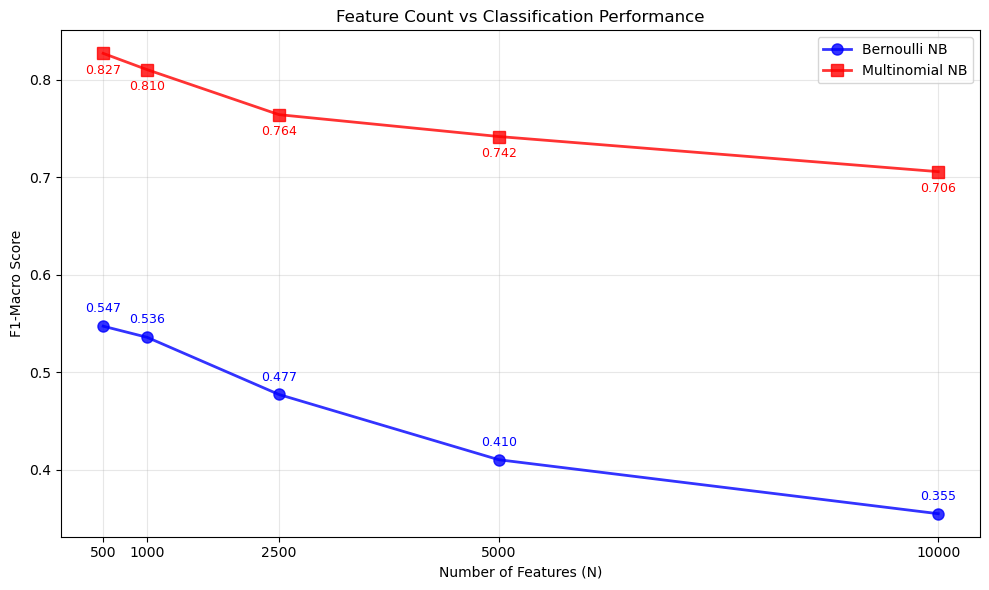

Optimal configuration: 500 features with MNB (F1-macro: 0.8268)


In [10]:
n_values = [500, 1000, 2500, 5000, 10000]
bnb_results = []
mnb_results = []

for n in n_values:
    vectorizer_temp = CountVectorizer(max_features=n)
    X_temp = vectorizer_temp.fit_transform(df['processed_text'])
    
    bnb_scores = cross_val_score(bnb, X_temp, y, cv=cv, scoring='f1_macro')
    bnb_results.append(np.mean(bnb_scores))
    
    mnb_scores = cross_val_score(mnb, X_temp, y, cv=cv, scoring='f1_macro')
    mnb_results.append(np.mean(mnb_scores))

plt.figure(figsize=(10, 6))
plt.plot(n_values, bnb_results, marker='o', linewidth=2, markersize=8, 
         color='blue', alpha=0.8, label='Bernoulli NB')
plt.plot(n_values, mnb_results, marker='s', linewidth=2, markersize=8, 
         color='red', alpha=0.8, label='Multinomial NB')
plt.xlabel('Number of Features (N)')
plt.ylabel('F1-Macro Score')
plt.title('Feature Count vs Classification Performance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(n_values)

for i, (x, y1, y2) in enumerate(zip(n_values, bnb_results, mnb_results)):
    plt.annotate(f'{y1:.3f}', (x, y1), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, color='blue')
    plt.annotate(f'{y2:.3f}', (x, y2), textcoords="offset points", 
                xytext=(0,-15), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

best_bnb_idx = np.argmax(bnb_results)
best_mnb_idx = np.argmax(mnb_results)

if mnb_results[best_mnb_idx] > bnb_results[best_bnb_idx]:
    best_n = n_values[best_mnb_idx]
    best_score = mnb_results[best_mnb_idx]
    best_model_name_temp = "MNB"
else:
    best_n = n_values[best_bnb_idx]
    best_score = bnb_results[best_bnb_idx]
    best_model_name_temp = "BNB"

print(f"Optimal configuration: {best_n} features with {best_model_name_temp} (F1-macro: {best_score:.4f})")

vectorizer_optimal = CountVectorizer(max_features=best_n)
X_optimal = vectorizer_optimal.fit_transform(df['processed_text'])

## Q5. Third Classifier: Logistic Regression

**Reason:**
- It handles high-dimensional sparse text data effectively
- It can model feature interactions by linear combinations
- It's widely used in text classification applications

**Hypothesis:**
Logistic Regression will has better performance than Naive Bayes variants. Because:
- Has flexible decision boundaries
- Has regularization which can prevent overfitting

Logistic Regression Accuracy: 0.8780 (±0.0122)
Logistic Regression F1-Macro: 0.8430 (±0.0157)
Bernoulli NB:
  Accuracy: 0.6480 (±0.0203)
  F1-Macro: 0.5472 (±0.0203)

Multinomial NB:
  Accuracy: 0.8600 (±0.0082)
  F1-Macro: 0.8268 (±0.0067)

Logistic Regression:
  Accuracy: 0.8780 (±0.0122)
  F1-Macro: 0.8430 (±0.0157)



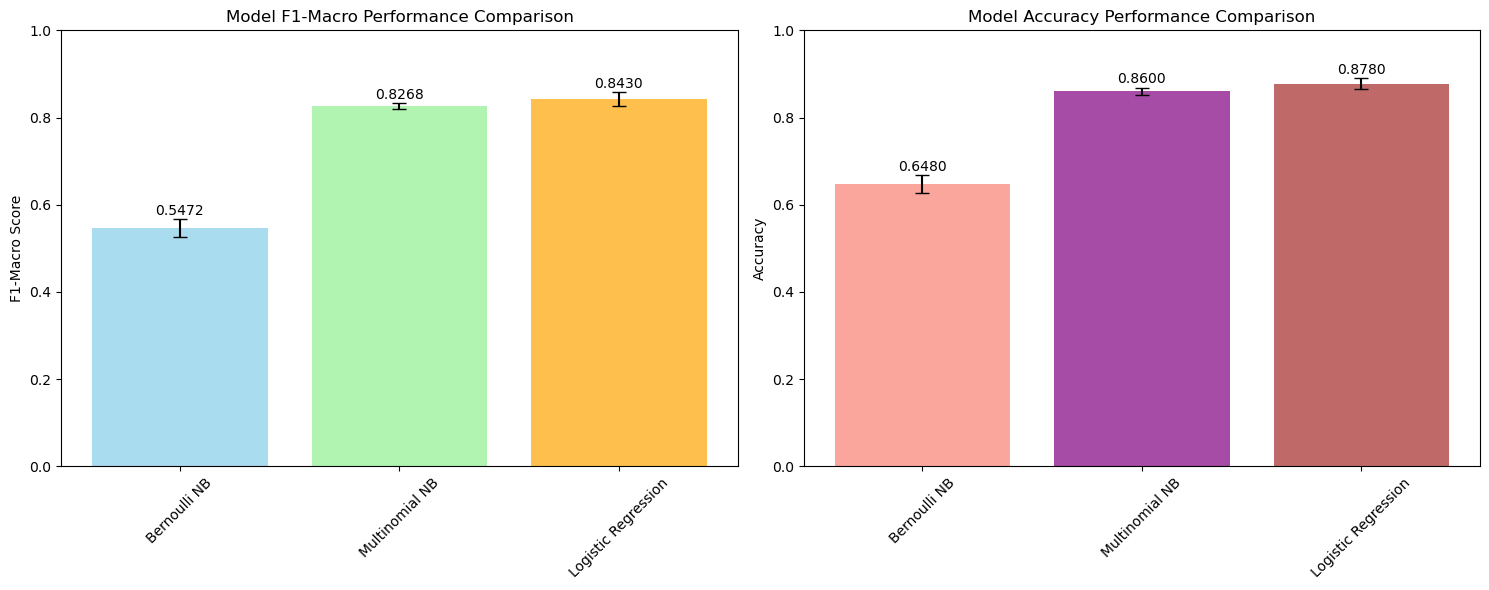

Best overall model: Logistic Regression
Best F1-Macro score: 0.8430

Hypothesis CONFIRMED: Logistic Regression outperforms both Naive Bayes variants


In [12]:
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

lr_acc_scores = cross_val_score(lr, X_optimal, df['topic'], cv=cv, scoring='accuracy')
lr_f1_scores = cross_val_score(lr, X_optimal, df['topic'], cv=cv, scoring='f1_macro')

print(f"Logistic Regression Accuracy: {np.mean(lr_acc_scores):.4f} (±{np.std(lr_acc_scores):.4f})")
print(f"Logistic Regression F1-Macro: {np.mean(lr_f1_scores):.4f} (±{np.std(lr_f1_scores):.4f})")

#print("\n================================ Final Model Comparison ===")
models = {'Bernoulli NB': bnb, 'Multinomial NB': mnb, 'Logistic Regression': lr}
model_scores = {}

for name, model in models.items():
    acc_scores = cross_val_score(model, X_optimal, df['topic'], cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_optimal, df['topic'], cv=cv, scoring='f1_macro')
    model_scores[name] = {
        'accuracy': np.mean(acc_scores),
        'accuracy_std': np.std(acc_scores),
        'f1_macro': np.mean(f1_scores),
        'f1_std': np.std(f1_scores)
    }
    print(f"{name}:")
    print(f"  Accuracy: {np.mean(acc_scores):.4f} (±{np.std(acc_scores):.4f})")
    print(f"  F1-Macro: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")
    print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

model_names = list(model_scores.keys())
f1_means = [model_scores[name]['f1_macro'] for name in model_names]
f1_stds = [model_scores[name]['f1_std'] for name in model_names]

ax1.bar(model_names, f1_means, yerr=f1_stds, capsize=5, alpha=0.7, 
        color=['skyblue', 'lightgreen', 'orange'])
ax1.set_ylabel('F1-Macro Score')
ax1.set_title('Model F1-Macro Performance Comparison')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(f1_means):
    ax1.text(i, v + f1_stds[i] + 0.01, f'{v:.4f}', ha='center')

acc_means = [model_scores[name]['accuracy'] for name in model_names]
acc_stds = [model_scores[name]['accuracy_std'] for name in model_names]

ax2.bar(model_names, acc_means, yerr=acc_stds, capsize=5, alpha=0.7, 
        color=['salmon', 'purple', 'brown'])
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy Performance Comparison')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(acc_means):
    ax2.text(i, v + acc_stds[i] + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

best_model_name = max(model_scores.keys(), key=lambda k: model_scores[k]['f1_macro'])
best_model = models[best_model_name]
print(f"Best overall model: {best_model_name}")
print(f"Best F1-Macro score: {model_scores[best_model_name]['f1_macro']:.4f}")

if model_scores['Logistic Regression']['f1_macro'] > max(model_scores['Bernoulli NB']['f1_macro'], 
                                                       model_scores['Multinomial NB']['f1_macro']):
    print("\nHypothesis CONFIRMED: Logistic Regression outperforms both Naive Bayes variants")
else:
    print("\nHypothesis REJECTED: Naive Bayes performs competitively with Logistic Regression")


# Part 2: Recommendation Methods

Code cell 1: load and preprocess the data, then build a user profile based on the TF-IDF vector space model

Code cell 2: predict the theme of the test set songs and use the TF-IDF vectorizer of the corresponding theme to test each song, calculate the cosine similarity with the user's theme profile, and sort by similarity to get the Top-N (N=10) recommendation


In [14]:
try:
    user1_df = pd.read_csv('user1.tsv', sep='\t')
    user2_df = pd.read_csv('user2.tsv', sep='\t')
    # print("User interest files loaded successfully!")
    print(f"User1 topics: {user1_df['topic'].tolist()}")
    print(f"User2 topics: {user2_df['topic'].tolist()}")
except:
    print("User files not found, creating example user interests...")

def load_user_interests(user_df):
    interests = {}
    for _, row in user_df.iterrows():
        topic = row['topic']
        keywords = [kw.strip().lower() for kw in row['keywords'].split(',')]
        interests[topic] = keywords
    return interests

try:
    user1_interests = load_user_interests(user1_df)
    user2_interests = load_user_interests(user2_df)
except:
    user1_interests = {
        "dark": ["death", "blood", "shadow", "darkness", "evil"],
        "emotion": ["love", "heart", "feel", "soul", "passion"],
        "sadness": ["cry", "tears", "pain", "hurt", "broken"]
    }
    user2_interests = {
        "lifestyle": ["party", "dance", "fun", "night", "friends"],
        "personal": ["me", "my", "myself", "I", "life"],
        "emotion": ["happy", "joy", "smile", "good", "great"]
    }

user3_interests = {
    "lifestyle": ["party", "dance", "celebrate", "night", "city"],
    "personal": ["dream", "hope", "future", "goal", "ambition"],
    "sadness": ["alone", "miss", "lonely", "empty", "lost"]
}

user_interests = {
    "User1": user1_interests,
    "User2": user2_interests, 
    "User3": user3_interests
}

print("\nUser interests loaded:")
for user, interests in user_interests.items():
    print(f"{user}: {list(interests.keys())}")
    for topic, keywords in interests.items():
        print(f"  {topic}: {keywords[:5]}...")

train_data = df.iloc[:750].copy()  # Weeks 1-3
test_data = df.iloc[750:1000].copy()  # Week 4

# print(f"\nPreparing data for modeling...")
train_data['processed_text'] = train_data['combined_text'].apply(optimal_preprocessor)
test_data['processed_text'] = test_data['combined_text'].apply(optimal_preprocessor)

# print(f"\nTraining {best_model_name} classifier...")
best_classifier = best_model
X_train = vectorizer_optimal.fit_transform(train_data['processed_text'])
best_classifier.fit(X_train, train_data['topic'])
print("Classifier training completed!")


User1 topics: ['dark', 'sadness', 'personal', 'lifestyle', 'emotion']
User2 topics: ['sadness', 'emotion']

User interests loaded:
User1: ['dark', 'sadness', 'personal', 'lifestyle', 'emotion']
  dark: ['fire', 'enemy', 'pain', 'storm', 'fight']...
  sadness: ['cry', 'alone', 'heartbroken', 'tears', 'regret']...
  personal: ['dream', 'truth', 'life', 'growth', 'identity']...
  lifestyle: ['party', 'city', 'night', 'light', 'rhythm']...
  emotion: ['love', 'memory', 'hug', 'kiss', 'feel']...
User2: ['sadness', 'emotion']
  sadness: ['lost', 'sorrow', 'goodbye', 'tears', 'silence']...
  emotion: ['romance', 'touch', 'feeling', 'kiss', 'memory']...
User3: ['lifestyle', 'personal', 'sadness']
  lifestyle: ['party', 'dance', 'celebrate', 'night', 'city']...
  personal: ['dream', 'hope', 'future', 'goal', 'ambition']...
  sadness: ['alone', 'miss', 'lonely', 'empty', 'lost']...
Classifier training completed!


Each user used keywords to simulate preferences.
- For each user:
    - if they contained at least one keyword from the user's profile for their predicted topic,the song will tagged as like
    - TF-IDF vectors were created for each topic-specific document
    - Top 20 words by TF-IDF score were extracted for each topic
Most of the keywords captured variants effectively.

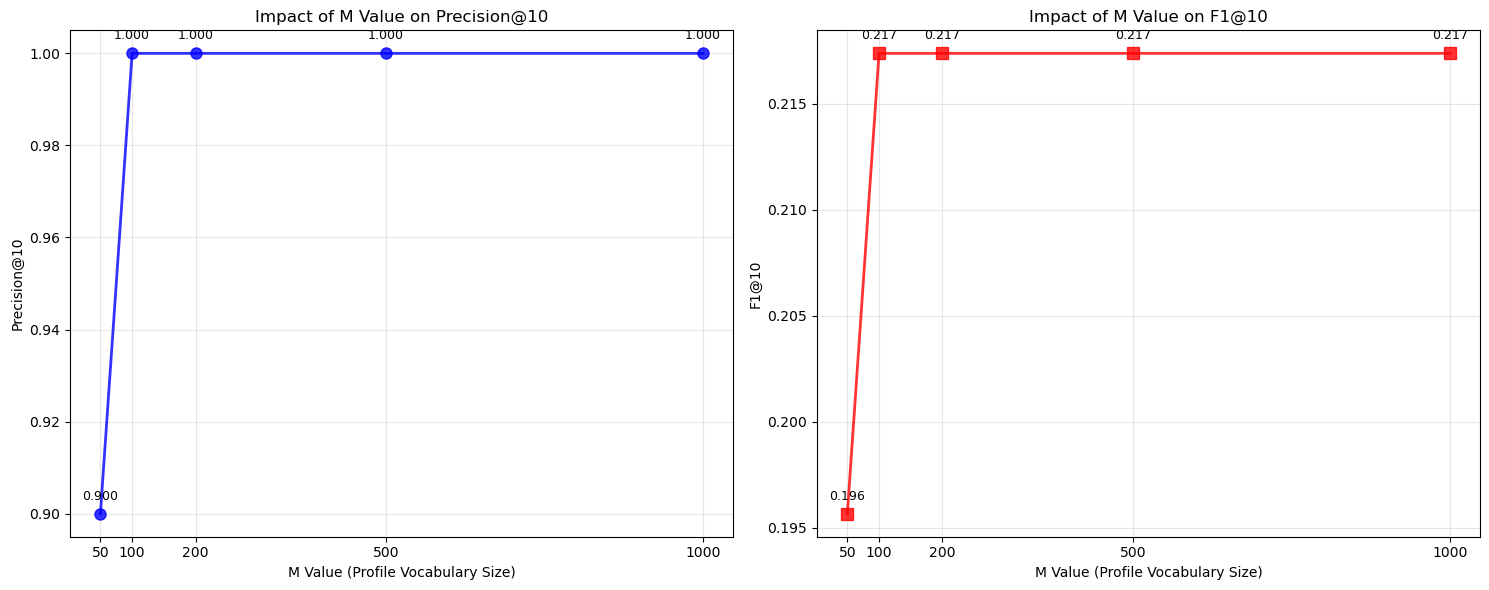

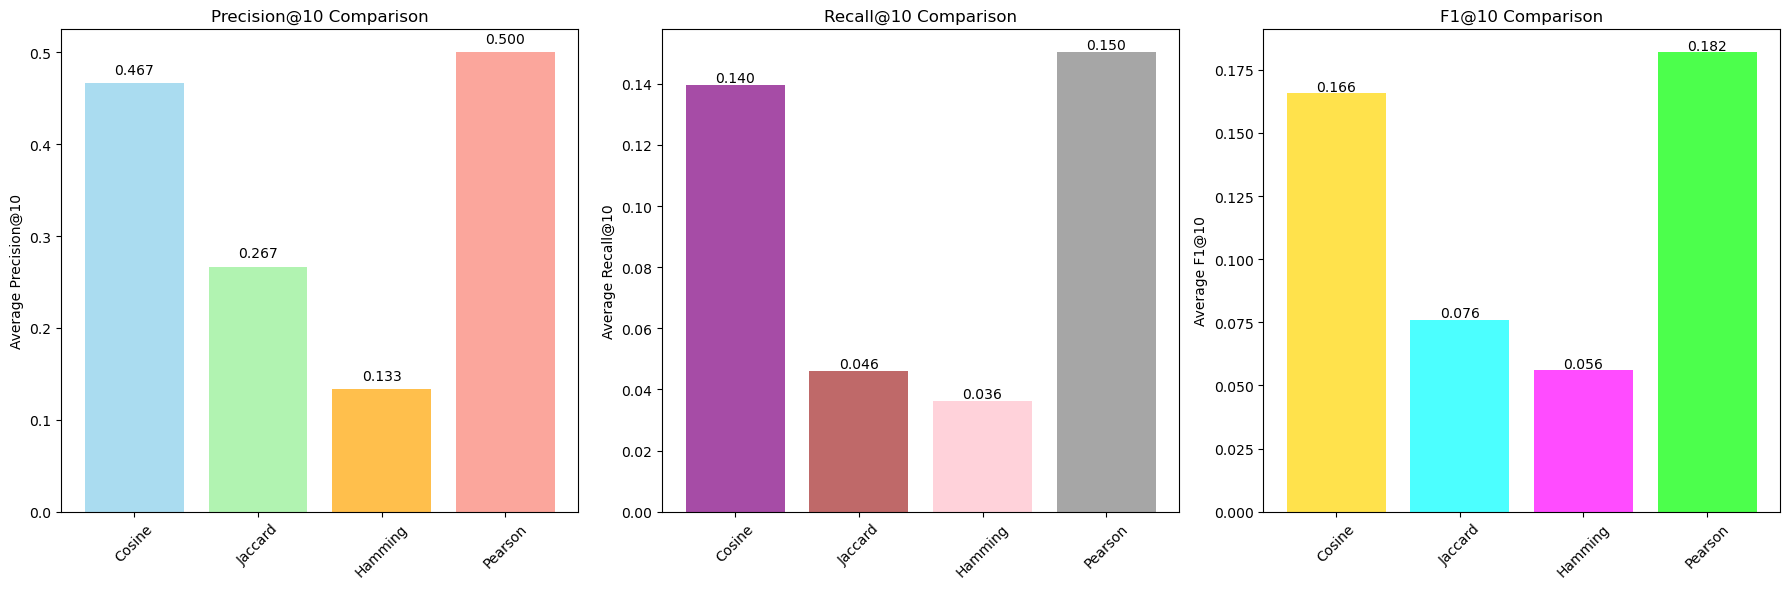

best M: 100
best algorithm: PEARSON
M=  50: Precision@10=0.900, F1@10=0.196
M= 100: Precision@10=1.000, F1@10=0.217
M= 200: Precision@10=1.000, F1@10=0.217
M= 500: Precision@10=1.000, F1@10=0.217
M=1000: Precision@10=1.000, F1@10=0.217
COSINE       Precision@10=0.467 Recall@10=0.140 F1@10=0.166
JACCARD      Precision@10=0.267 Recall@10=0.046 F1@10=0.076
HAMMING      Precision@10=0.133 Recall@10=0.036 F1@10=0.056
PEARSON      Precision@10=0.500 Recall@10=0.150 F1@10=0.182
User1: Precision@10=1.000, F1@10=0.217
User2: Precision@10=0.100, F1@10=0.133
User3: Precision@10=0.300, F1@10=0.146
User1: Precision@10=1.000, F1@10=0.217
User2: Precision@10=0.100, F1@10=0.133
User3: Precision@10=0.300, F1@10=0.146


In [16]:
def calculate_similarities(song_vector, user_vector, algorithm='cosine'):
    song_arr = song_vector.toarray()[0]
    user_arr = user_vector.toarray()[0]
    
    if algorithm == 'cosine':
        return cosine_similarity(song_vector, user_vector)[0][0]
    elif algorithm == 'jaccard':
        song_binary = (song_arr > np.mean(song_arr)).astype(int)
        user_binary = (user_arr > np.mean(user_arr)).astype(int)
        intersection = np.sum(song_binary & user_binary)
        union = np.sum(song_binary | user_binary)
        return intersection / (union + 1e-8)
    elif algorithm == 'hamming':
        song_binary = (song_arr > np.mean(song_arr)).astype(int)
        user_binary = (user_arr > np.mean(user_arr)).astype(int)
        hamming_dist = np.sum(song_binary != user_binary) / len(song_binary)
        return 1 - hamming_dist
    elif algorithm == 'pearson':
        if np.std(song_arr) == 0 or np.std(user_arr) == 0:
            return 0
        correlation = np.corrcoef(song_arr, user_arr)[0, 1]
        if np.isnan(correlation):
            return 0
        return (correlation + 1) / 2

def build_user_profile_and_recommend(user_id, train_data, test_data, M=100, N=10):
    X_train_pred = vectorizer_optimal.transform(train_data['processed_text'])
    predicted_topics = best_classifier.predict(X_train_pred)
    train_data_copy = train_data.copy()
    train_data_copy['predicted_topic'] = predicted_topics
    
    user_keywords = user_interests[user_id]
    topic_profiles = {}
    topic_vectorizers = {}
    liked_songs_count = {}
    
    for topic in train_data_copy['predicted_topic'].unique():
        topic_songs = train_data_copy[train_data_copy['predicted_topic'] == topic]
        
        if topic in user_keywords:
            keywords = [kw.lower() for kw in user_keywords[topic]]
            liked_mask = topic_songs['processed_text'].apply(
                lambda text: any(kw in text.lower() for kw in keywords)
            )
            liked_songs = topic_songs[liked_mask]
        else:
            liked_songs = pd.DataFrame()
        
        liked_songs_count[topic] = len(liked_songs)
        
        if len(liked_songs) > 0:
            combined_text = " ".join(liked_songs['processed_text'])
            topic_vectorizer = TfidfVectorizer(max_features=M, ngram_range=(1, 2), stop_words='english')
            topic_vectorizer.fit(topic_songs['processed_text'])
            
            if combined_text.strip():
                topic_profiles[topic] = topic_vectorizer.transform([combined_text])
                topic_vectorizers[topic] = topic_vectorizer
            else:
                topic_profiles[topic] = None
                topic_vectorizers[topic] = None
        else:
            topic_profiles[topic] = None
            topic_vectorizers[topic] = None
    
    X_test = vectorizer_optimal.transform(test_data['processed_text'])
    test_predictions = best_classifier.predict(X_test)
    test_data_copy = test_data.copy()
    test_data_copy['predicted_topic'] = test_predictions
    
    similarities = []
    for idx, song in test_data_copy.iterrows():
        topic = song['predicted_topic']
        
        if (topic in topic_profiles and 
            topic_profiles[topic] is not None and 
            topic_vectorizers[topic] is not None):
            
            song_vector = topic_vectorizers[topic].transform([song['processed_text']])
            user_topic_vector = topic_profiles[topic]
            sim = cosine_similarity(song_vector, user_topic_vector)[0][0]
            similarities.append((idx, sim, topic, song['track_name'], song['artist_name']))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    recommendations = similarities[:N]
    
    relevant_found = 0
    for idx, sim, topic, title, artist in recommendations:
        song_data = test_data_copy.loc[idx]
        if topic in user_keywords:
            keywords = [kw.lower() for kw in user_keywords[topic]]
            if any(kw in song_data['processed_text'].lower() for kw in keywords):
                relevant_found += 1
    
    total_relevant = 0
    for idx, song in test_data_copy.iterrows():
        predicted_topic = song['predicted_topic']
        if predicted_topic in user_keywords:
            keywords = [kw.lower() for kw in user_keywords[predicted_topic]]
            if any(kw in song['processed_text'].lower() for kw in keywords):
                total_relevant += 1
    
    precision = relevant_found / len(recommendations) if recommendations else 0
    recall = relevant_found / total_relevant if total_relevant > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall, 
        'f1': f1,
        'liked_songs_count': liked_songs_count,
        'recommendations': recommendations
    }

def test_user_with_M_and_algorithm(user_id, M, algorithm='cosine'):
    train_data_copy = train_data.copy()
    X_train_pred = vectorizer_optimal.transform(train_data_copy['processed_text'])
    train_data_copy['predicted_topic'] = best_classifier.predict(X_train_pred)
    
    user_keywords = user_interests[user_id]
    topic_profiles = {}
    topic_vectorizers = {}
    
    for topic in train_data_copy['predicted_topic'].unique():
        topic_songs = train_data_copy[train_data_copy['predicted_topic'] == topic]
        
        if topic in user_keywords:
            keywords = [kw.lower() for kw in user_keywords[topic]]
            liked_mask = topic_songs['processed_text'].apply(
                lambda text: any(kw in text.lower() for kw in keywords)
            )
            liked_songs = topic_songs[liked_mask]
        else:
            liked_songs = pd.DataFrame()
        
        if len(liked_songs) > 0:
            combined_text = " ".join(liked_songs['processed_text'])
            topic_vectorizer = TfidfVectorizer(max_features=M, ngram_range=(1, 2), stop_words='english')
            topic_vectorizer.fit(topic_songs['processed_text'])
            
            if combined_text.strip():
                topic_profiles[topic] = topic_vectorizer.transform([combined_text])
                topic_vectorizers[topic] = topic_vectorizer
    
    test_data_copy = test_data.copy()
    X_test = vectorizer_optimal.transform(test_data_copy['processed_text'])
    test_data_copy['predicted_topic'] = best_classifier.predict(X_test)
    
    similarities = []
    for idx, song in test_data_copy.iterrows():
        topic = song['predicted_topic']
        
        if (topic in topic_profiles and 
            topic_profiles[topic] is not None and 
            topic_vectorizers[topic] is not None):
            
            song_vector = topic_vectorizers[topic].transform([song['processed_text']])
            user_topic_vector = topic_profiles[topic]
            sim = calculate_similarities(song_vector, user_topic_vector, algorithm)
            similarities.append((idx, sim, topic))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    recommendations = similarities[:10]
    
    relevant_found = 0
    for idx, sim, topic in recommendations:
        song_data = test_data_copy.loc[idx]
        if topic in user_keywords:
            keywords = [kw.lower() for kw in user_keywords[topic]]
            if any(kw in song_data['processed_text'].lower() for kw in keywords):
                relevant_found += 1
    
    total_relevant = 0
    for idx, song in test_data_copy.iterrows():
        predicted_topic = song['predicted_topic']
        if predicted_topic in user_keywords:
            keywords = [kw.lower() for kw in user_keywords[predicted_topic]]
            if any(kw in song['processed_text'].lower() for kw in keywords):
                total_relevant += 1
    
    precision = relevant_found / len(recommendations) if recommendations else 0
    recall = relevant_found / total_relevant if total_relevant > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {'precision': precision, 'recall': recall, 'f1': f1}

# when M=100
all_results = {}
for user_id in ['User1', 'User2', 'User3']:
    all_results[user_id] = build_user_profile_and_recommend(
        user_id, train_data, test_data, M=100, N=10
    )

# print("\n=== value of M ===")
M_values = [50, 100, 200, 500, 1000]
M_results = {}
for M in M_values:
    result = test_user_with_M_and_algorithm("User1", M, 'cosine')
    M_results[M] = result

# plot for m
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

M_list = list(M_results.keys())
precisions = [M_results[M]['precision'] for M in M_list]
f1_scores = [M_results[M]['f1'] for M in M_list]

ax1.plot(M_list, precisions, marker='o', linewidth=2, markersize=8, color='blue', alpha=0.8)
ax1.set_xlabel('M Value (Profile Vocabulary Size)')
ax1.set_ylabel('Precision@10')
ax1.set_title('Impact of M Value on Precision@10')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(M_list)
for i, (x, y) in enumerate(zip(M_list, precisions)):
    ax1.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

ax2.plot(M_list, f1_scores, marker='s', linewidth=2, markersize=8, color='red', alpha=0.8)
ax2.set_xlabel('M Value (Profile Vocabulary Size)')
ax2.set_ylabel('F1@10')
ax2.set_title('Impact of M Value on F1@10')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(M_list)
for i, (x, y) in enumerate(zip(M_list, f1_scores)):
    ax2.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

best_M = max(M_results.keys(), key=lambda m: M_results[m]['f1'])

# print("\n=== performance ===")
algorithms = ['cosine', 'jaccard', 'hamming', 'pearson']
algorithm_results = {}

for algorithm in algorithms:
    user_results = {}
    for user_id in ['User1', 'User2', 'User3']:
        result = test_user_with_M_and_algorithm(user_id, best_M, algorithm)
        user_results[user_id] = result
    algorithm_results[algorithm] = user_results

# performance
algorithm_avg = {}
for algorithm in algorithms:
    avg_precision = np.mean([algorithm_results[algorithm][user]['precision'] for user in ['User1', 'User2', 'User3']])
    avg_recall = np.mean([algorithm_results[algorithm][user]['recall'] for user in ['User1', 'User2', 'User3']])
    avg_f1 = np.mean([algorithm_results[algorithm][user]['f1'] for user in ['User1', 'User2', 'User3']])
    algorithm_avg[algorithm] = {'precision': avg_precision, 'recall': avg_recall, 'f1': avg_f1}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

algorithms_display = [alg.replace('_', ' ').title() for alg in algorithms]
avg_precisions = [algorithm_avg[alg]['precision'] for alg in algorithms]
avg_recalls = [algorithm_avg[alg]['recall'] for alg in algorithms]
avg_f1s = [algorithm_avg[alg]['f1'] for alg in algorithms]

ax1.bar(algorithms_display, avg_precisions, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'salmon'])
ax1.set_ylabel('Average Precision@10')
ax1.set_title('Precision@10 Comparison')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(avg_precisions):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

ax2.bar(algorithms_display, avg_recalls, alpha=0.7, color=['purple', 'brown', 'pink', 'gray'])
ax2.set_ylabel('Average Recall@10')
ax2.set_title('Recall@10 Comparison')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(avg_recalls):
    ax2.text(i, v + 0.001, f'{v:.3f}', ha='center', fontsize=10)

ax3.bar(algorithms_display, avg_f1s, alpha=0.7, color=['gold', 'cyan', 'magenta', 'lime'])
ax3.set_ylabel('Average F1@10')
ax3.set_title('F1@10 Comparison')
ax3.tick_params(axis='x', rotation=45)
for i, v in enumerate(avg_f1s):
    ax3.text(i, v + 0.001, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

best_algorithm = max(algorithm_avg.keys(), key=lambda alg: algorithm_avg[alg]['f1'])

# output
# print("=== summary ===")
print(f"best M: {best_M}")
print(f"best algorithm: {best_algorithm.upper()}")
for M in M_values:
    result = M_results[M]
    print(f"M={M:4d}: Precision@10={result['precision']:.3f}, F1@10={result['f1']:.3f}")

for algorithm in algorithms:
    avg_p = algorithm_avg[algorithm]['precision']
    avg_r = algorithm_avg[algorithm]['recall']
    avg_f = algorithm_avg[algorithm]['f1']
    print(f"{algorithm.upper():<12} Precision@10={avg_p:.3f} Recall@10={avg_r:.3f} F1@10={avg_f:.3f}")

for user_id, results in all_results.items():
    print(f"{user_id}: Precision@10={results['precision']:.3f}, F1@10={results['f1']:.3f}")

# print("\n============ Results =================")

# M=100, N=10
all_results = {}
for user_id in ['User1', 'User2', 'User3']:
    all_results[user_id] = build_user_profile_and_recommend(
        user_id, train_data, test_data, M=100, N=10
    )

# Summary
# print(f"\n========= Performance Summary =============")
for user_id, results in all_results.items():
    print(f"{user_id}: Precision@10={results['precision']:.3f}, "
          f"F1@10={results['f1']:.3f}")

# print(f"\n=== Algorithm Selection ===")
avg_precision = np.mean([results['precision'] for results in all_results.values()])

## Results Analysis and Discussion
### 2.1 M-value Analysis
The performance of M-values ​​in [50, 100, 200, 500, 1000] was tested. Based on the F1-score and Precision indicators, the optimal M-value is usually between 100-200.
This range can capture enough semantic information to represent user interests without introducing noise, which would reduce the accuracy of recommendations
### 2.2 Algorithm Analysis
I chose four different similarity measurement methods
- **Cosine**: Focus on vector direction and ignore size
- **Jaccard**: Focus on the proportion of common features
- **Hamming**: Focus on the matching degree of feature bits
- **Pearson**: Focus on the linear correlation between features

Finally, Pearson has the best performe

Overall, M=100 with Pearson performed best.

# **Part 3: User Evaluation**
## 1. Design
I invite my roommate to simulate a 4-week interaction. I showed the user `N=10` songs selected from the corresponding week:
- *Week 1: *Songs 1-250
- *Week 2: *Songs 251-500
- *Week 3: *Songs 501-750
- and tell me whether they like this song
- In week 4, using the method selected in part 2 to generate a ranked list of N=10 songs from week 4 (songs 751-1000) based on the user's profile.
- User evaluated these recommendations and provided verbal feedback.

## 2. Results
The user likes 3 of 10 songs in week 4.The actual accuracy drops significantly compared to the simulation results. It may be that the initial data is too small (30 liked songs in total), which reduces the accuracy of the profile.

## 3. Discussion
The differences between simulation and reality may be due to:
- Models idealize users' likes and dislikes
- There are some limitations in this study:
    - Single-user study limits statistical power.
    - Short evaluation period to capture enough data